<a href="https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of single-cell RNA-seq data: building and annotating an atlas
This R notebook pre-processes the [pbmc_1k v3 dataset](https://support.10xgenomics.com/single-cell-gene-expression/datasets/3.0.0/pbmc_1k_v3) from 10X Genomics with kallisto and bustools using `kb`, and then performs an analysis of the cell types and their marker genes.

The notebook was written by A. Sina Booeshaghi, Lambda Lu and Lior Pachter and is based on three noteboks:
- The kallisto | bustools [Introduction to single-cell RNA-seq I](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_1_minute_intro.ipynb#scrollTo=wtwMjIjjCMcD) notebook.
- The kallisto | bustools [Introduction to single-cell RNA-seq II](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_standard.ipynb#scrollTo=ijU_u6uj3Sio) notebook.
- The Seurat [Guided Clustering Tutorial](https://satijalab.org/seurat/v3.1/pbmc3k_tutorial.html).

If you use the methods in this notebook for your analysis please cite the following publications which describe the tools used in the notebook:

* Melsted, P., Booeshaghi, A.S. et al. Modular and efficient pre-processing of single-cell RNA-seq. bioRxiv (2019). doi:10.1101/673285
* Stuart, Butler et al. Comprehensive Integration of Single-cell Data. Cell (2019). doi:10.1016/j.cell.2019.05.031

A Python notebook implementing the same analysis is available [here](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_python.ipynb#scrollTo=3kZG9UyUPE_B). See the [kallistobus.tools tutorials](https://www.kallistobus.tools/tutorials) site for additional notebooks demonstrating other analyses.


## Setup

In [0]:
# This is used to time the running of the notebook
start_time <- Sys.time()

### Install R packages
A large fraction of the running time of this notebook is in installing the Seurat R package, since it has lots of dependencies and many of them use Rcpp which results in the need to compile lots of C++ code.

In [0]:
system.time({
  if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
  BiocManager::install(c('multtest', "DropletUtils"), Ncpus = 2)
  # Seurat was removed from CRAN on Feb 7
  # Install Seurat dependencies with 2 threads
  install.packages(c("ape", "cluster", "cowplot", "fitdistrplus", "future", "future.apply", 
"ggrepel", "ggridges", "httr", "ica", "igraph", "irlba", "leiden", "lmtest", "metap", "pbapply", 
"plotly", "png", "RANN", "RColorBrewer", "RcppAnnoy", "reticulate", 
"rlang", "ROCR", "rsvd", "Rtsne", "scales", "sctransform", "SDMTools", 
"tsne", "uwot", "scico"), Ncpus = 2)
  devtools::install_github("satijalab/Seurat")
})

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.2 (2019-12-12)

Installing package(s) 'BiocVersion', 'multtest', 'DropletUtils'

also installing the dependencies ‘zlibbioc’, ‘bitops’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘formatR’, ‘GenomicRanges’, ‘GenomeInfoDb’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘SummarizedExperiment’, ‘futile.logger’, ‘snow’, ‘limma’, ‘locfit’, ‘DelayedArray’, ‘IRanges’, ‘R.oo’, ‘R.methodsS3’, ‘sitmo’, ‘BiocGenerics’, ‘Biobase’, ‘SingleCellExperiment’, ‘S4Vectors’, ‘BiocParallel’, ‘edgeR’, ‘rhdf5’, ‘HDF5Array’, ‘R.utils’, ‘dqrng’, ‘beachmat’, ‘Rhdf5lib’


Old packages: 'curl', 'DT', 'farver', 'jsonlite', 'knitr', 'mime', 'rprojroot',
  'rstudioapi', 'svglite', 'xfun', 'xtable', 'nlme'

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘mnormt’, ‘numDeriv’, ‘TH.data’, ‘sandwich’, ‘lsei’, ‘bibtex’, ‘

curl     (4.2   -> 4.3  ) [CRAN]
jsonlite (1.6   -> 1.6.1) [CRAN]
mime     (0.8   -> 0.9  ) [CRAN]
farver   (2.0.1 -> 2.0.3) [CRAN]
xtable   (1.8-3 -> 1.8-4) [CRAN]


Skipping 3 packages ahead of CRAN: multtest, BiocGenerics, Biobase

Installing 5 packages: curl, jsonlite, mime, farver, xtable

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpxYnpP2/remotes766bb59517/satijalab-seurat-49a1be0/DESCRIPTION’
─  preparing ‘Seurat’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘Seurat_3.1.2.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



    user   system  elapsed 
2467.462  219.185 1542.399 

The package installation took 26 minutes which is almost half the running time of the notebook.

### Install kb-python

In [0]:
# Install kb (includes installing kallisto and bustools)
system("pip3 install kb-python", intern=TRUE)

[1] "Collecting kb-python"                                                                                                                                                                 
 [2] "  Downloading https://files.pythonhosted.org/packages/62/c9/2e5b8fa2cd873a23ae1aeb128b33165d6a9387a2f56ea1fafec1d6d32477/kb_python-0.24.4-py3-none-any.whl (35.4MB)"                  
 [3] "Collecting loompy>=3.0.6"                                                                                                                                                             
 [4] "  Downloading https://files.pythonhosted.org/packages/36/52/74ed37ae5988522fbf87b856c67c4f80700e6452410b4cd80498c5f416f9/loompy-3.0.6.tar.gz (41kB)"                                  
 [5] "Collecting anndata>=0.6.22.post1"                                                                                                                                                     
 [6] "  Downloading https://files.pythonhosted.org/packages/5b/c8/5c594a95ba293433dfe1cf188075ccbabe495bf2d291be744974aca85ffc/anndata-0.7.1-py3-none-any.whl (97kB)"                       
 [7] "Requirement already satisfied: h5py in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (2.8.0)"                                                                
 [8] "Requirement already satisfied: numpy in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (1.17.5)"                                                              
 [9] "Requirement already satisfied: scipy in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (1.4.1)"                                                               
[10] "Requirement already satisfied: setuptools in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (45.1.0)"                                                         
[11] "Requirement already satisfied: numba in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (0.47.0)"                                                              
[12] "Requirement already satisfied: click in /usr/local/lib/python3.6/dist-packages (from loompy>=3.0.6->kb-python) (7.0)"                                                                 
[13] "Collecting numpy-groupies"                                                                                                                                                            
[14] "  Downloading https://files.pythonhosted.org/packages/57/ae/18217b57ba3e4bb8a44ecbfc161ed065f6d1b90c75d404bd6ba8d6f024e2/numpy_groupies-0.9.10.tar.gz (43kB)"                         
[15] "Requirement already satisfied: pandas>=0.23.0 in /usr/local/lib/python3.6/dist-packages (from anndata>=0.6.22.post1->kb-python) (0.25.3)"                                             
[16] "Requirement already satisfied: packaging in /usr/local/lib/python3.6/dist-packages (from anndata>=0.6.22.post1->kb-python) (20.1)"                                                    
[17] "Requirement already satisfied: importlib-metadata>=0.7; python_version < \"3.8\" in /usr/local/lib/python3.6/dist-packages (from anndata>=0.6.22.post1->kb-python) (1.5.0)"           
[18] "Requirement already satisfied: natsort in /usr/local/lib/python3.6/dist-packages (from anndata>=0.6.22.post1->kb-python) (5.5.0)"                                                     
[19] "Requirement already satisfied: six in /usr/local/lib/python3.6/dist-packages (from h5py->loompy>=3.0.6->kb-python) (1.12.0)"                                                          
[20] "Requirement already satisfied: llvmlite>=0.31.0dev0 in /usr/local/lib/python3.6/dist-packages (from numba->loompy>=3.0.6->kb-python) (0.31.0)"                                        
[21] "Requirement already satisfied: pytz>=2017.2 in /usr/local/lib/python3.6/dist-packages (from pandas>=0.23.0->anndata>=0.6.22.post1->kb-python) (2018.9)"                               
[22] "Requirement already satisf

### Download the data

In [0]:
# Download the data from the 10x website
system("wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_1k_v3/pbmc_1k_v3_fastqs.tar", intern=TRUE)
system("tar -xvf pbmc_1k_v3_fastqs.tar", intern=TRUE)

character(0)

[1] "pbmc_1k_v3_fastqs/"                                  
[2] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz"
[3] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_I1_001.fastq.gz"
[4] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz"
[5] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz"
[6] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz"
[7] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_I1_001.fastq.gz"

### Download an index

In [0]:
system("kb ref -d human -i index.idx -g t2g.txt -f1 transcriptome.fasta",intern=TRUE)

character(0)

## Pseudoalignment and counting

### Run kallisto and bustools

In [0]:
system("kb count -i index.idx -g t2g.txt -x 10xv3 -o output --filter bustools -t 2 pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz",intern=TRUE)

character(0)

## Basic QC

In [0]:
library(DropletUtils)
library(Seurat)
library(Matrix)
library(tidyverse)
library(scico)
theme_set(theme_bw())

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tap

In [0]:
list.files(".", recursive = TRUE)

[1] "index.idx"                                           
 [2] "output/10xv3_whitelist.txt"                          
 [3] "output/counts_filtered/cells_x_genes.barcodes.txt"   
 [4] "output/counts_filtered/cells_x_genes.genes.txt"      
 [5] "output/counts_filtered/cells_x_genes.mtx"            
 [6] "output/counts_unfiltered/cells_x_genes.barcodes.txt" 
 [7] "output/counts_unfiltered/cells_x_genes.genes.txt"    
 [8] "output/counts_unfiltered/cells_x_genes.mtx"          
 [9] "output/filter_barcodes.txt"                          
[10] "output/inspect.json"                                 
[11] "output/matrix.ec"                                    
[12] "output/output.bus"                                   
[13] "output/output.filtered.bus"                          
[14] "output/output.unfiltered.bus"                        
[15] "output/run_info.json"                                
[16] "output/transcripts.txt"                              
[17] "pbmc_1k_v3_fastqs.tar"                               
[18] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_I1_001.fastq.gz"
[19] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R1_001.fastq.gz"
[20] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L001_R2_001.fastq.gz"
[21] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_I1_001.fastq.gz"
[22] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R1_001.fastq.gz"
[23] "pbmc_1k_v3_fastqs/pbmc_1k_v3_S1_L002_R2_001.fastq.gz"
[24] "sample_data/anscombe.json"                           
[25] "sample_data/california_housing_test.csv"             
[26] "sample_data/california_housing_train.csv"            
[27] "sample_data/mnist_test.csv"                          
[28] "sample_data/mnist_train_small.csv"                   
[29] "sample_data/README.md"                               
[30] "t2g.txt"

In [0]:
# Slightly modified from BUSpaRse, just to avoid installing a few dependencies not used here
read_count_output <- function(dir, name) {
  dir <- normalizePath(dir, mustWork = TRUE)
  m <- readMM(paste0(dir, "/", name, ".mtx"))
  m <- Matrix::t(m)
  m <- as(m, "dgCMatrix")
  # The matrix read has cells in rows
  ge <- ".genes.txt"
  genes <- readLines(file(paste0(dir, "/", name, ge)))
  barcodes <- readLines(file(paste0(dir, "/", name, ".barcodes.txt")))
  colnames(m) <- barcodes
  rownames(m) <- genes
  return(m)
}

In [0]:
res_mat <- read_count_output("./output/counts_unfiltered", name = "cells_x_genes")

In [0]:
dim(res_mat)

[1]  60623 259615

### Test for library saturation

In [0]:
tot_counts <- colSums(res_mat)
lib_sat <- tibble(nCount = tot_counts,
                  nGene = colSums(res_mat > 0))

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


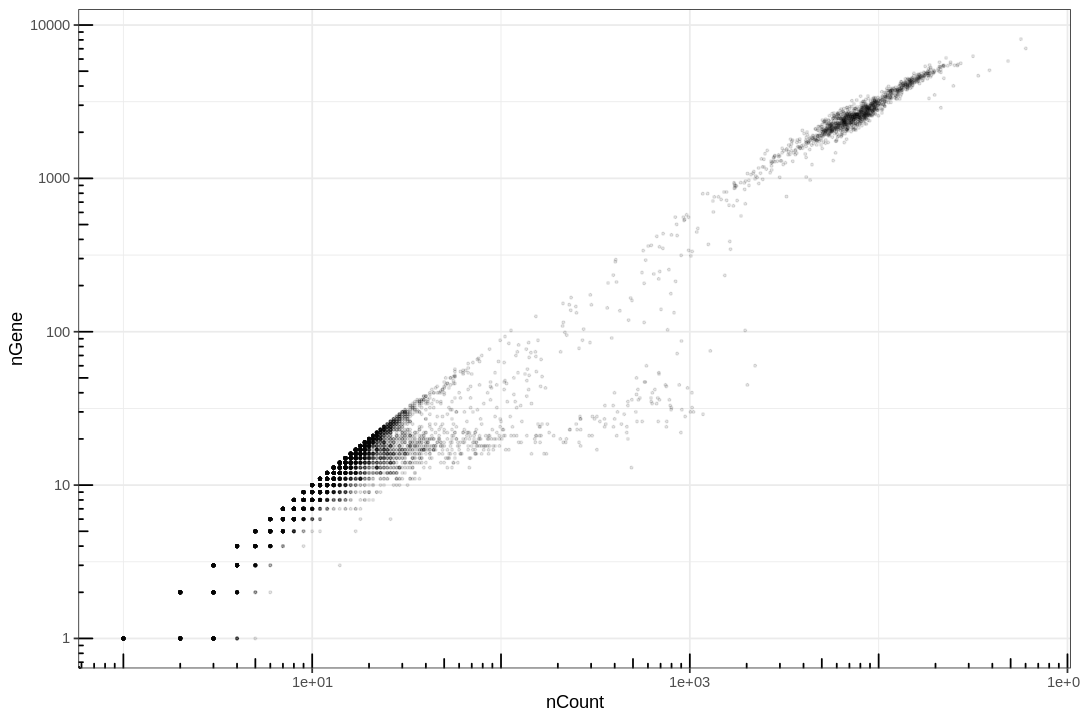

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
ggplot(lib_sat, aes(nCount, nGene)) +
  geom_point(alpha = 0.1, size = 0.5) +
  scale_x_log10() + scale_y_log10() + annotation_logticks()

This plot is very misleading, as even the small alpha can't accurately show how many points are stacked at one location.

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 19583 rows containing non-finite values (stat_bin2d).”


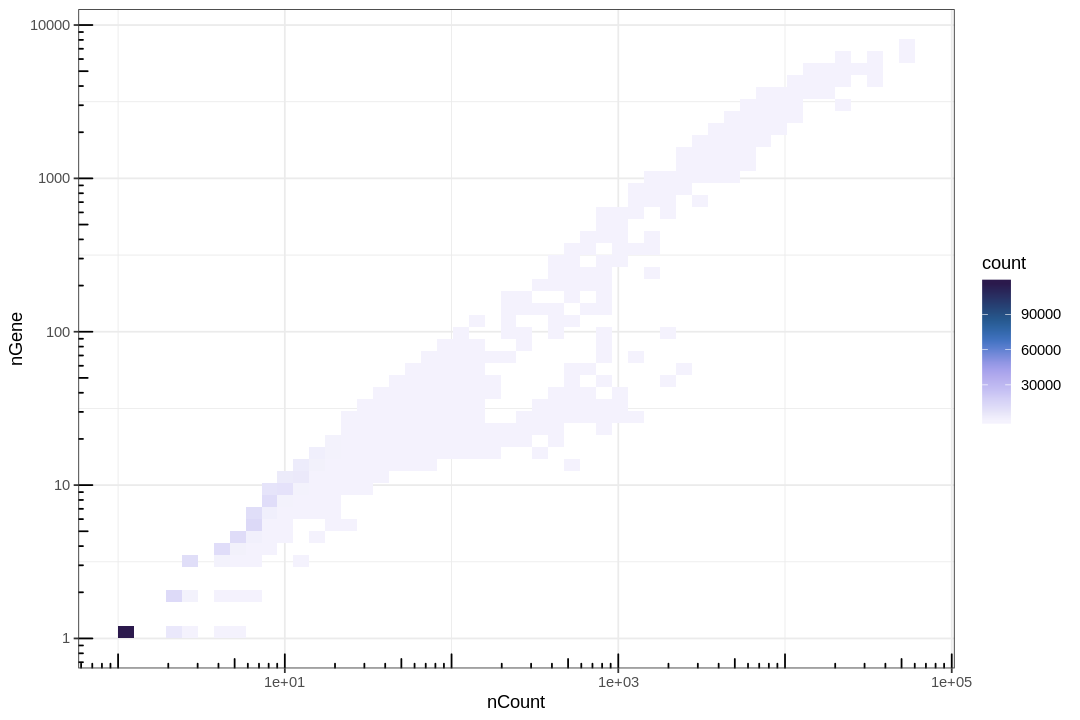

In [0]:
ggplot(lib_sat, aes(nCount, nGene)) +
  geom_bin2d(bins = 50) +
  scale_fill_scico(palette = "devon", direction = -1, end = 0.95) +
  scale_x_log10() + scale_y_log10() + annotation_logticks()

Lots of points are piled at around 1 gene and 1 count, and correspond to empty or near empty droplets.

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

In [0]:
summary(tot_counts)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     1.00     1.00    43.64     6.00 60120.00 

In [0]:
bc_rank <- barcodeRanks(res_mat, lower = 1000)

In [0]:
#' Knee plot for filtering empty droplets
#' 
#' Visualizes the inflection point to filter empty droplets. This function plots 
#' different datasets with a different color. Facets can be added after calling
#' this function with `facet_*` functions. Will be added to the next release
#' version of BUSpaRse.
#' 
#' @param bc_rank A `DataFrame` output from `DropletUtil::barcodeRanks`.
#' @return A ggplot2 object.
knee_plot <- function(bc_rank) {
  knee_plt <- tibble(rank = bc_rank[["rank"]],
                     total = bc_rank[["total"]]) %>% 
    distinct() %>% 
    dplyr::filter(total > 0)
  annot <- tibble(inflection = metadata(bc_rank)[["inflection"]],
                  rank_cutoff = max(bc_rank$rank[bc_rank$total > metadata(bc_rank)[["inflection"]]]))
  p <- ggplot(knee_plt, aes(total, rank)) +
    geom_line() +
    geom_hline(aes(yintercept = rank_cutoff), data = annot, linetype = 2) +
    geom_vline(aes(xintercept = inflection), data = annot, linetype = 2) +
    scale_x_log10() +
    scale_y_log10() +
    annotation_logticks() +
    labs(y = "Rank", x = "Total UMIs")
  return(p)
}

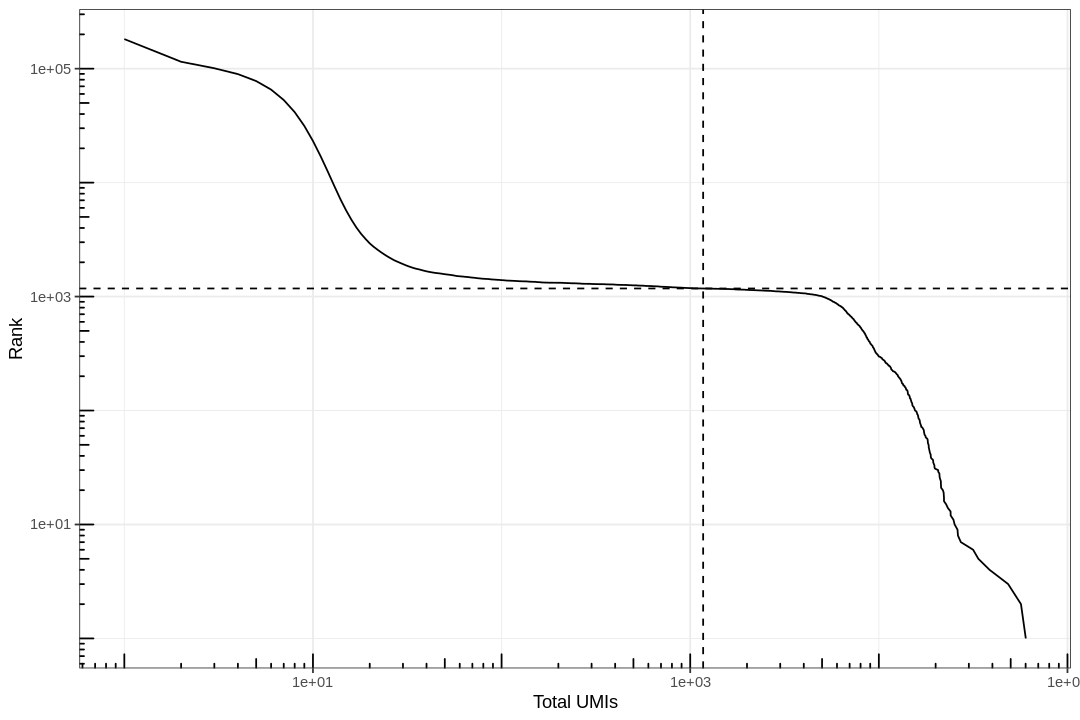

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
knee_plot(bc_rank)

## Analysis
We begin by asking for genes with the highest proportions in droplets (prior to filtering out empty droplets).

In [0]:
tr2g <- read_tsv("t2g.txt", col_names = c("transcript", "gene", "gene_name"))
tr2g <- distinct(tr2g[, c("gene", "gene_name")])

Parsed with column specification:
cols(
  transcript = col_character(),
  gene = col_character(),
  gene_name = col_character()
)



In [0]:
plot_pct_genes <- function(mat, tr2g, top_n = 20, symbol = "ensembl") {
  pct_tx <- rowSums(mat)
  gs <- rownames(mat)[order(-pct_tx)]
  df <- as.data.frame(t(mat[gs[1:20],]))
  df <- df %>%
    mutate_all(function(x) x/colSums(mat)) %>%
    pivot_longer(everything(), names_to = "gene")
  if (symbol == "ensembl") {
    df <- left_join(df, tr2g, by = "gene")
  } else {
    df <- rename(df, gene_name = gene)
  }
    df %>%
    mutate(gene = fct_reorder(gene_name, value, .fun = median)) %>%
    ggplot(aes(gene, value)) +
    geom_boxplot() +
    labs(x = "", y = "Proportion of total counts") +
    coord_flip()
}

Warning message:
“Removed 391660 rows containing non-finite values (stat_boxplot).”


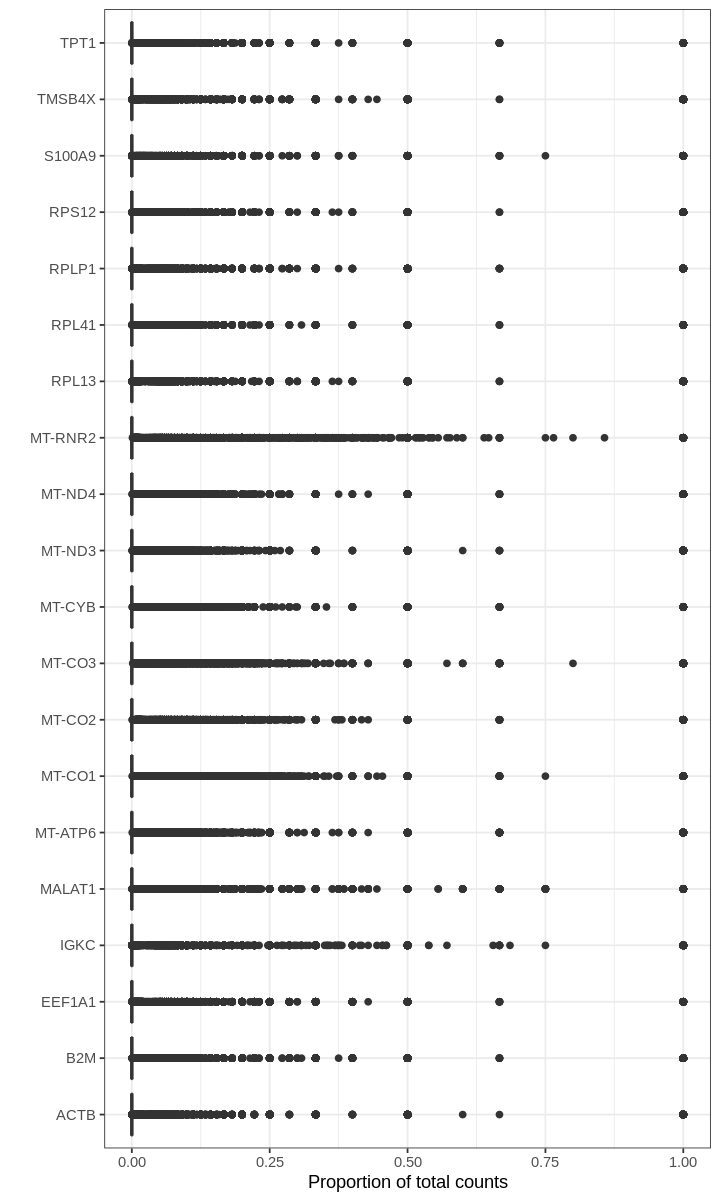

In [0]:
options(repr.plot.width=6, repr.plot.height=10)
plot_pct_genes(res_mat, tr2g)

For many barcodes, the top genes by proportion of all counts are ribosomal or mitochondrial genes. Also, the proportions plotted above seem to have some discrete values; this effect is a result of computing fractions with small denominator, which happens when droplets produce very few UMI counts.

### Filter

In [0]:
res_mat <- res_mat[, tot_counts > metadata(bc_rank)$inflection]
res_mat <- res_mat[Matrix::rowSums(res_mat) > 0,]
dim(res_mat)

[1] 31832  1178

In [0]:
# Convert from Ensembl gene ID to gene symbol
rownames(res_mat) <- tr2g$gene_name[match(rownames(res_mat), tr2g$gene)]

In [0]:
(pbmc <- CreateSeuratObject(counts = res_mat, project = "pbmc1k", min.cells = 3, min.features = 200))

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
25950 features across 1173 samples within 1 assay 
Active assay: RNA (25950 features)

The steps below constitute a standard analysis worklow for single-cell RNA-seq data. 

In [0]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

The number of unique genes and total molecules are automatically calculated when running the `CreateSeuratObject` command.
The associated data is stored in the object metadata.


In [0]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCAAGGAGAGTA,pbmc1k,9289,3198,11.271396
AAACGCTTCAGCCCAG,pbmc1k,6483,2513,8.252352
AAAGAACAGACGACTG,pbmc1k,5011,2082,6.166434
AAAGAACCAATGGCAG,pbmc1k,3264,1555,6.893382
AAAGAACGTCTGCAAT,pbmc1k,7488,2508,6.610577


Next, we visualize some QC metrics and use the results to set filtering criteria.

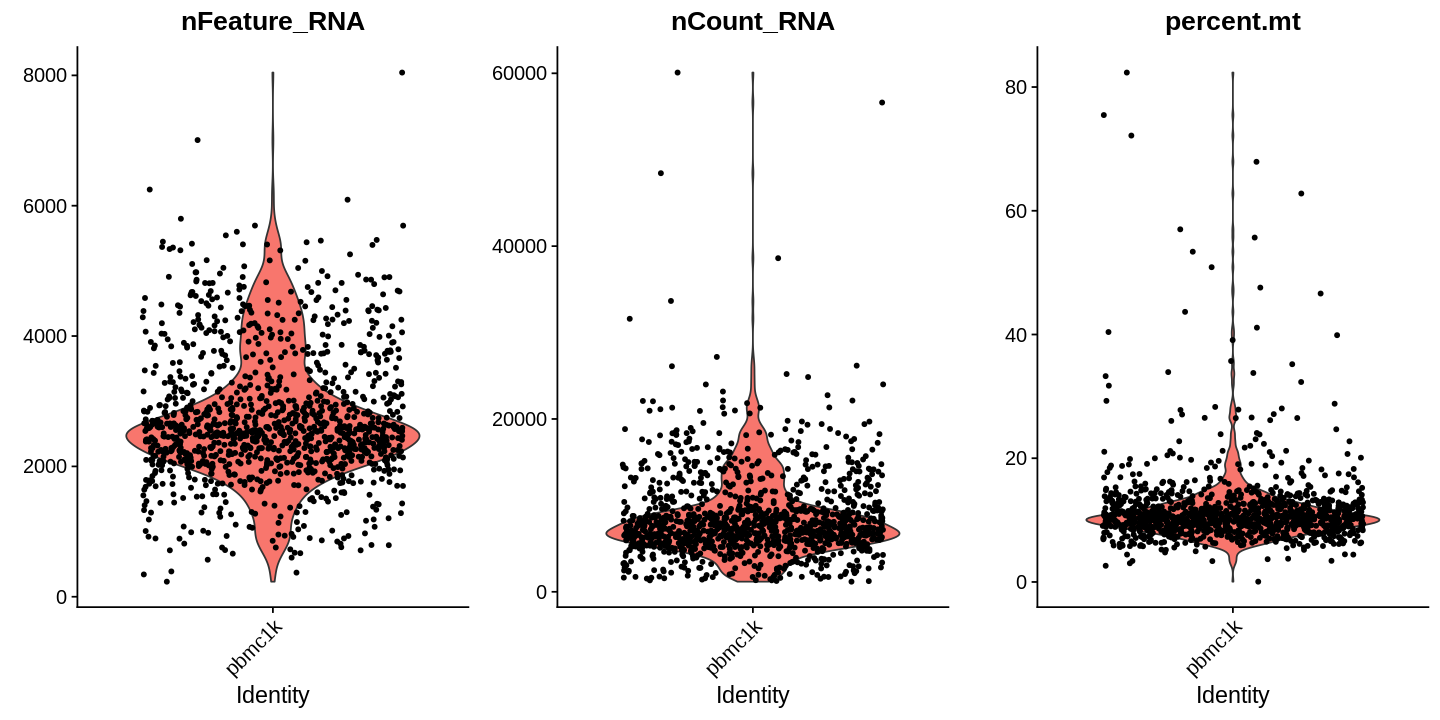

In [0]:
# Visualize QC metrics as a violin plot
options(repr.plot.width=12, repr.plot.height=6)
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

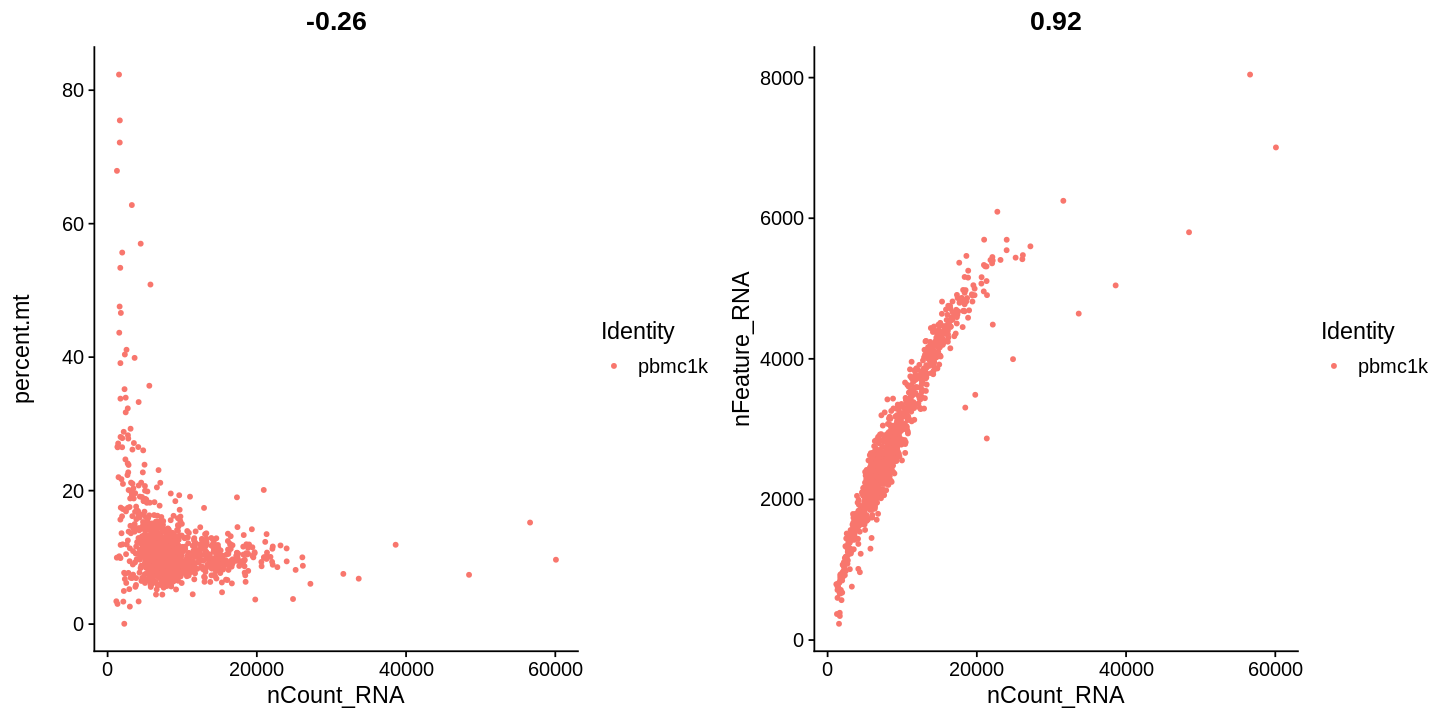

In [0]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))

In [0]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 6500 & percent.mt < 20)

### Normalize

After removing unwanted cells from the dataset, the next step is to normalize the data. A standard choice is `LogNormalize` which normalizes the UMI counts for each cell by the total counts, multiplies this by a scale factor (10,000 by default), and finally log-transforms the result. Normalized values are stored in pbmc[["RNA"]]@data. 

We recommend the preprint 
- Breda, J., Zavolan, M. and van Nimwegen, E. Bayesian inference of the gene expression states of single cells from scRNA-seq data. bioRxiv (2019). doi.org/10.1101/2019.12.28.889956 

for a thorough discussion of normalization.

In [0]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

For clarity, in this previous line of code (and in future commands), we provide the default values for certain parameters in the function call. However, this isn’t required and the same behavior can be achieved with:

In [0]:
# pbmc <- NormalizeData(pbmc)

### Highly expressed genes


To identify a subset of genes that exhibit high cell-to-cell variation in the dataset we apply a procedure implemented in the `FindVariableFeatures` function. By default, it returns 2,000 genes per dataset. These will be used in downstream analysis.

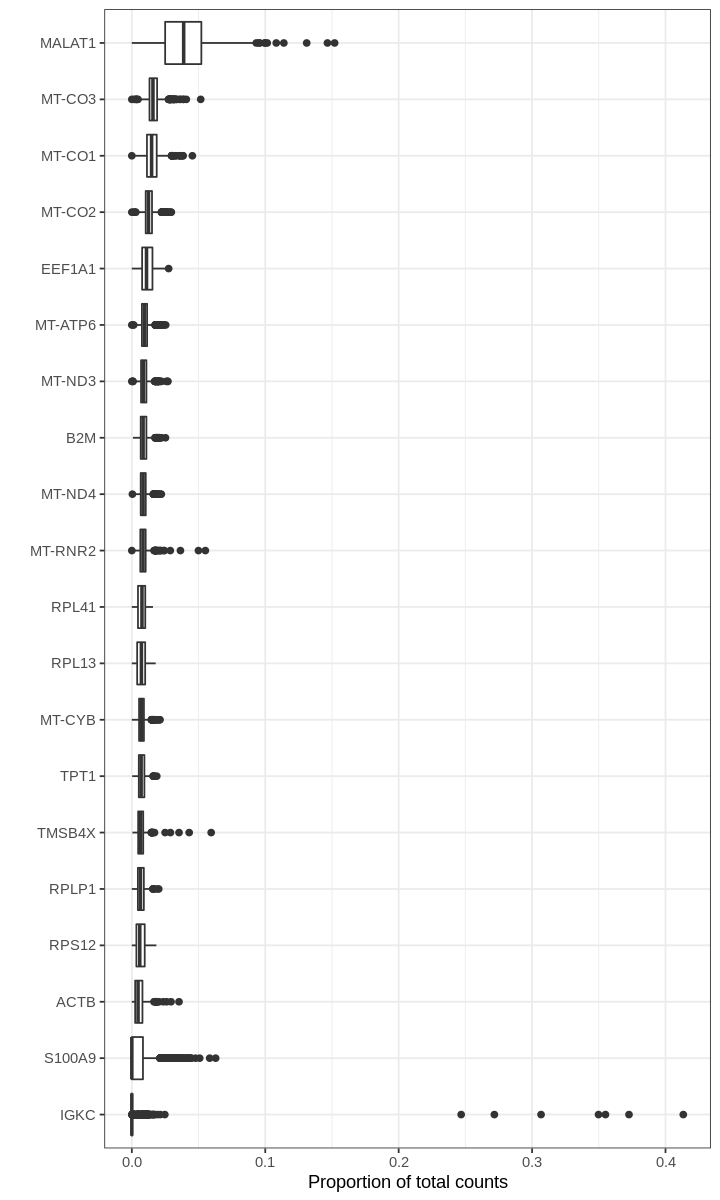

In [0]:
options(repr.plot.width=6, repr.plot.height=10)
plot_pct_genes(GetAssayData(pbmc, slot = "counts"), tr2g, symbol = "symbol")

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”
When using repel, set xnudge and ynudge to 0 for optimal results



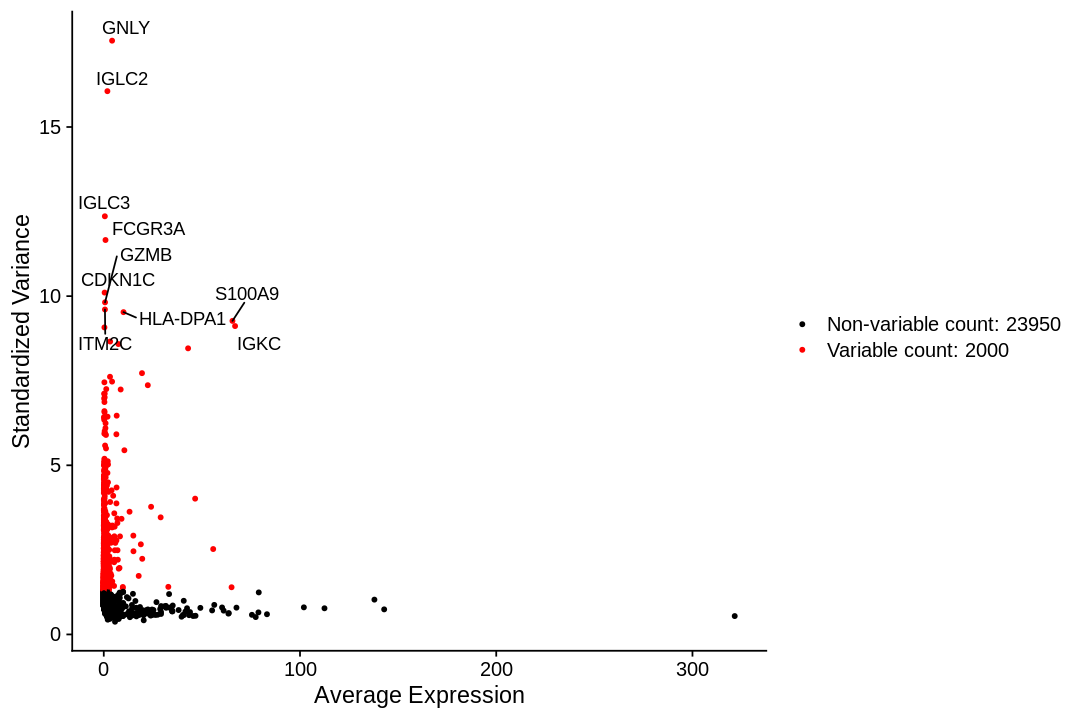

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc, log = FALSE)
LabelPoints(plot = plot1, points = top10, repel = TRUE)

### Scaling the data
Next, we apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The ScaleData function shifts the expression of each gene, so that the mean expression across cells is 0 and the variance across cells is 1
This step gives equal weight to genes in downstream analyses, so that highly-expressed genes do not dominate. The results of this are stored in pbmc[["RNA"]]@scale.data

In [0]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



We apply this only to the genes identified as highly variable:

In [0]:
# pbmc <- ScaleData(pbmc)


The scaling does not affect PCA or clustering results. However, Seurat heatmaps (produced as shown below with DoHeatmap) require genes in the heatmap to be scaled so that highly-expressed genes don’t dominate. To make sure we don’t leave any genes out of the heatmap later, we are scaling all genes in this tutorial.



In Seurat v2 we also use the ScaleData function to remove unwanted sources of variation from a single-cell dataset. For example, we could ‘regress out’ heterogeneity associated with (for example) cell cycle stage, or mitochondrial contamination. These features are still supported in ScaleData in Seurat v3, i.e.:

In [0]:
# pbmc <- ScaleData(pbmc, vars.to.regress = "percent.mt")

### Principal component analysis

Next we perform PCA on the scaled data. By default, only the previously determined variable features are used as input.

In [0]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  S100A9, FCN1, MNDA, CST3, FGL2, LYZ, S100A8, CTSS, NCF2, SERPINA1 
	   PSAP, AIF1, TYMP, VCAN, CSTA, KLF4, GRN, MPEG1, CPVL, MS4A6A 
	   CLEC7A, LST1, TNFAIP2, FCER1G, CD14, CYBB, LGALS1, S100A12, TYROBP, CD36 
Negative:  LTB, TRAC, CD3E, TRBC2, CD3D, IL32, BCL11B, CD3G, IL7R, TCF7 
	   CD69, ISG20, CD247, CD27, SPOCK2, ARL4C, CD7, CD2, GZMM, TRBC1 
	   CD6, PRKCQ-AS1, NOSIP, AC058791.1, RORA, CTSW, CCR7, AQP3, PEBP1, ITM2A 
PC_ 2 
Positive:  CD3E, IL32, CD247, GZMM, CD7, CTSW, CD3D, S100A4, GZMA, NKG7 
	   ANXA1, TRAC, BCL11B, CD3G, IL7R, PRF1, CST7, KLRB1, ARL4C, SAMD3 
	   CCL5, CD2, TRBC1, KLRG1, A2M, ITGB2, MT2A, RORA, ACTG1, TCF7 
Negative:  CD79A, MS4A1, IGHM, BANK1, BCL11A, LINC00926, CD79B, TNFRSF13C, IGHD, CD74 
	   HLA-DQB1, CD22, HLA-DQA1, HLA-DRB1, HLA-DRA, HLA-DPA1, HLA-DPB1, TCL1A, FCER2, AFF3 
	   PAX5, IGKC, VPREB3, SPIB, MEF2C, RALGPS2, HVCN1, FCRL1, CD40, HLA-DOB 
PC_ 3 
Positive:  PRKAR2B, CAVIN2, GNG11, PPBP, PF4, PTCRA, TUBB1, GP9, LY6G6F, ITGA2B

Seurat provides several useful ways of visualizing both cells and features that define the PCA, including VizDimReduction, DimPlot, and DimHeatmap



In [0]:
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  S100A9, FCN1, MNDA, CST3, FGL2 
Negative:  LTB, TRAC, CD3E, TRBC2, CD3D 
PC_ 2 
Positive:  CD3E, IL32, CD247, GZMM, CD7 
Negative:  CD79A, MS4A1, IGHM, BANK1, BCL11A 
PC_ 3 
Positive:  PRKAR2B, CAVIN2, GNG11, PPBP, PF4 
Negative:  FOS, DUSP1, VIM, NEAT1, EVI2B 
PC_ 4 
Positive:  LEF1, TCF7, IL7R, MAL, CCR7 
Negative:  GZMB, GNLY, NKG7, CLIC3, KLRF1 
PC_ 5 
Positive:  GNLY, FGFBP2, KLRF1, PRF1, NKG7 
Negative:  LILRA4, SCT, PACSIN1, SMPD3, LRRC26 


Which genes are contributing the most to the first 2 PCs?

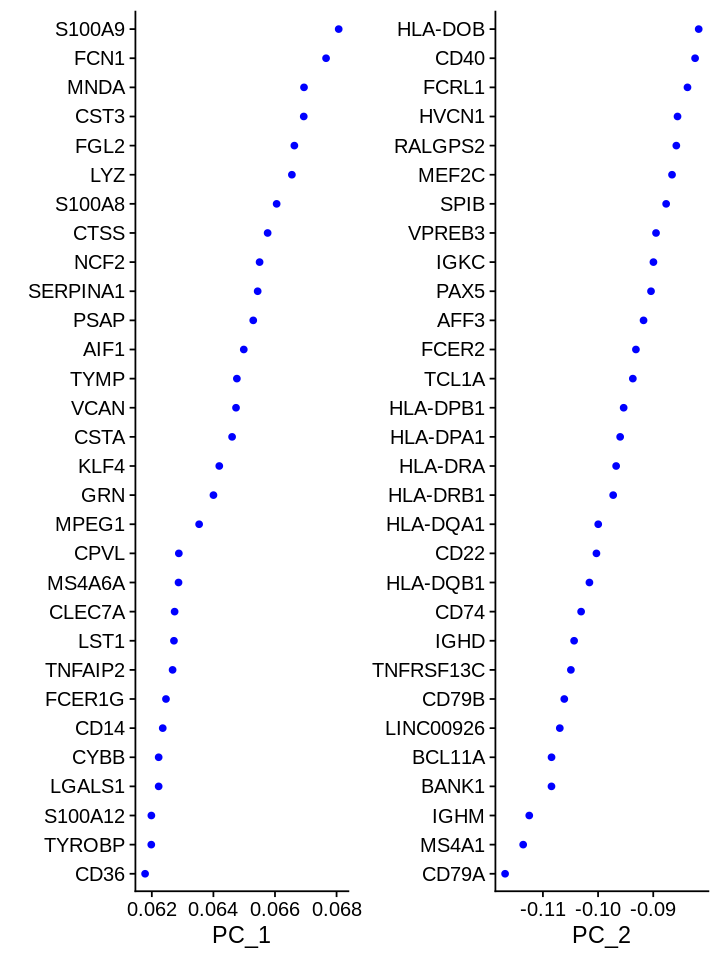

In [0]:
options(repr.plot.width=6, repr.plot.height=8)
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

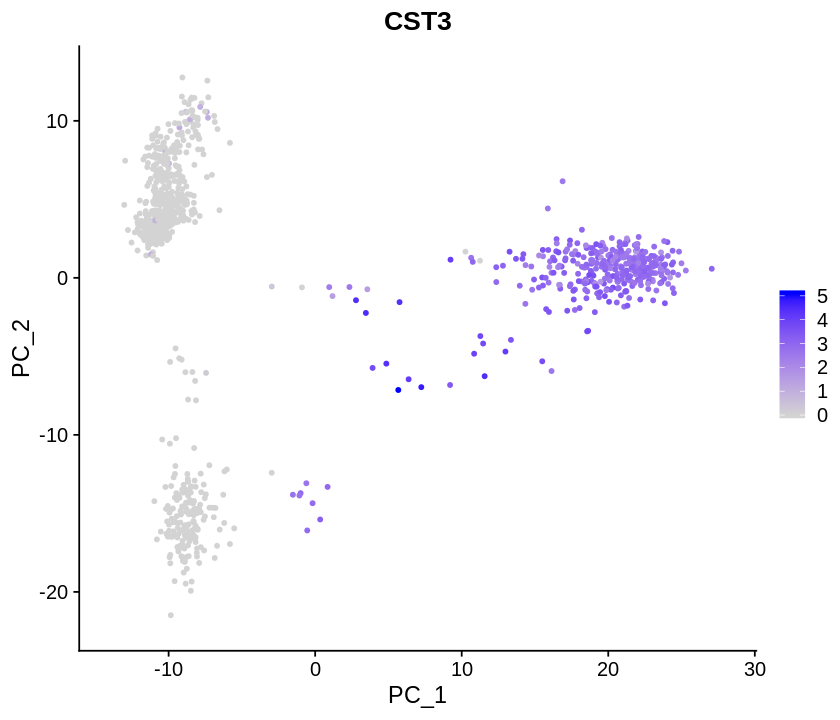

In [0]:
options(repr.plot.width=7, repr.plot.height=6)
FeaturePlot(pbmc, reduction = "pca", feature = "CST3")

### Determining dimensionality
To overcome the extensive technical noise in any single feature for scRNA-seq data, one can cluster cells based on their PCA projections, with each PC essentially representing a ‘metafeature’ that combines information across a correlated feature set.

A common heuristic method generates an ‘Elbow plot’: a ranking of principle components based on the percentage of variance explained by each one (ElbowPlot function). In this example, we can observe an ‘elbow’ around PC9-10, suggesting that the majority of true signal is captured in the first 10 PCs.

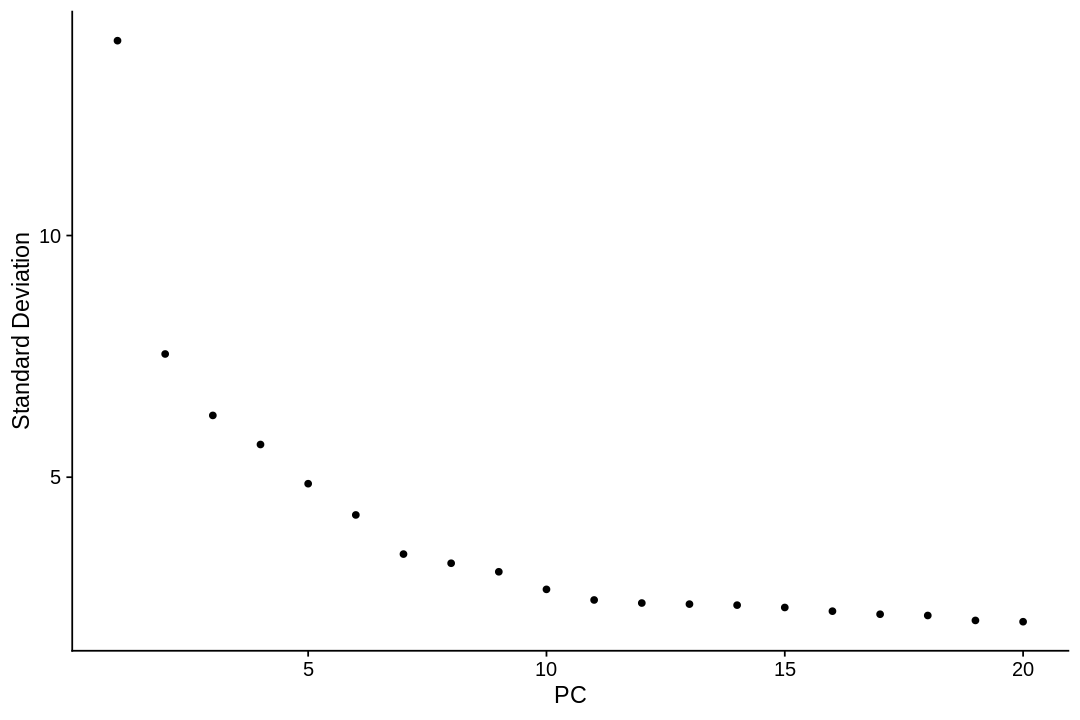

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
ElbowPlot(pbmc)

### The neighborhood graph

We cluster cells using the Louvain algorithm (a default in Seurat), which iteratively group cells together, with the goal of optimizing the standard modularity function. The FindClusters function implements this procedure, and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters. We find that setting this parameter between 0.4-1.2 typically returns good results for single-cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters can be found using the Idents function.

In [0]:
pbmc <- FindNeighbors(pbmc, dims = 1:10, k.param = 20)
pbmc <- FindClusters(pbmc, resolution = 0.6)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1113
Number of edges: 36080

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8763
Number of communities: 9
Elapsed time: 0 seconds


In [0]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACCCAAGGAGAGTA AAACGCTTCAGCCCAG AAAGAACAGACGACTG AAAGAACCAATGGCAG 
               1                4                5                5 
AAAGAACGTCTGCAAT 
               0 
Levels: 0 1 2 3 4 5 6 7 8

### UMAP and t-SNE
tSNE and UMAP can be used to visualize and explore non-linear aspects of high-dimensional data. Here we apply these methods to the PC projection of the data (with same dimension as used for clustering).

[UMAP](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction) (UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction) is a manifold learning technique that can also be used to visualize cells. It was published in:

- McInnes, Leland, John Healy, and James Melville. "Umap: Uniform manifold approximation and projection for dimension reduction." arXiv preprint arXiv:1802.03426 (2018).

[t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a non-linear dimensionality reduction technique described in:

- Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.Nov (2008): 2579-2605.



In [0]:
pbmc <- RunUMAP(pbmc, dims = 1:10, verbose = FALSE)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


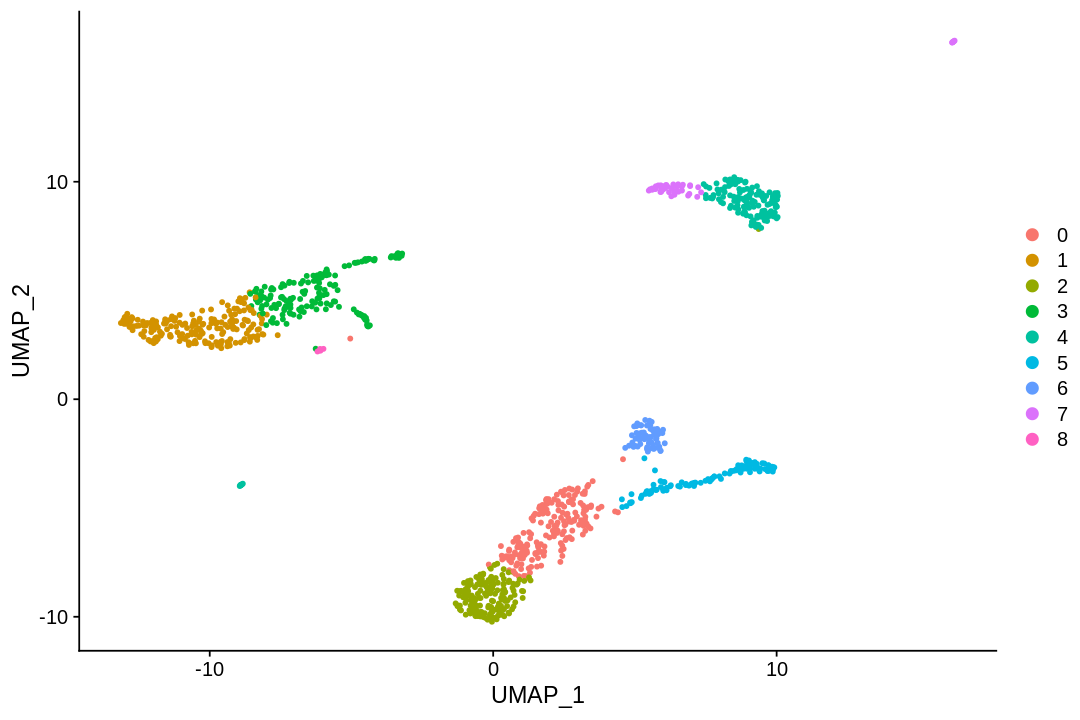

In [0]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(pbmc, reduction = "umap")

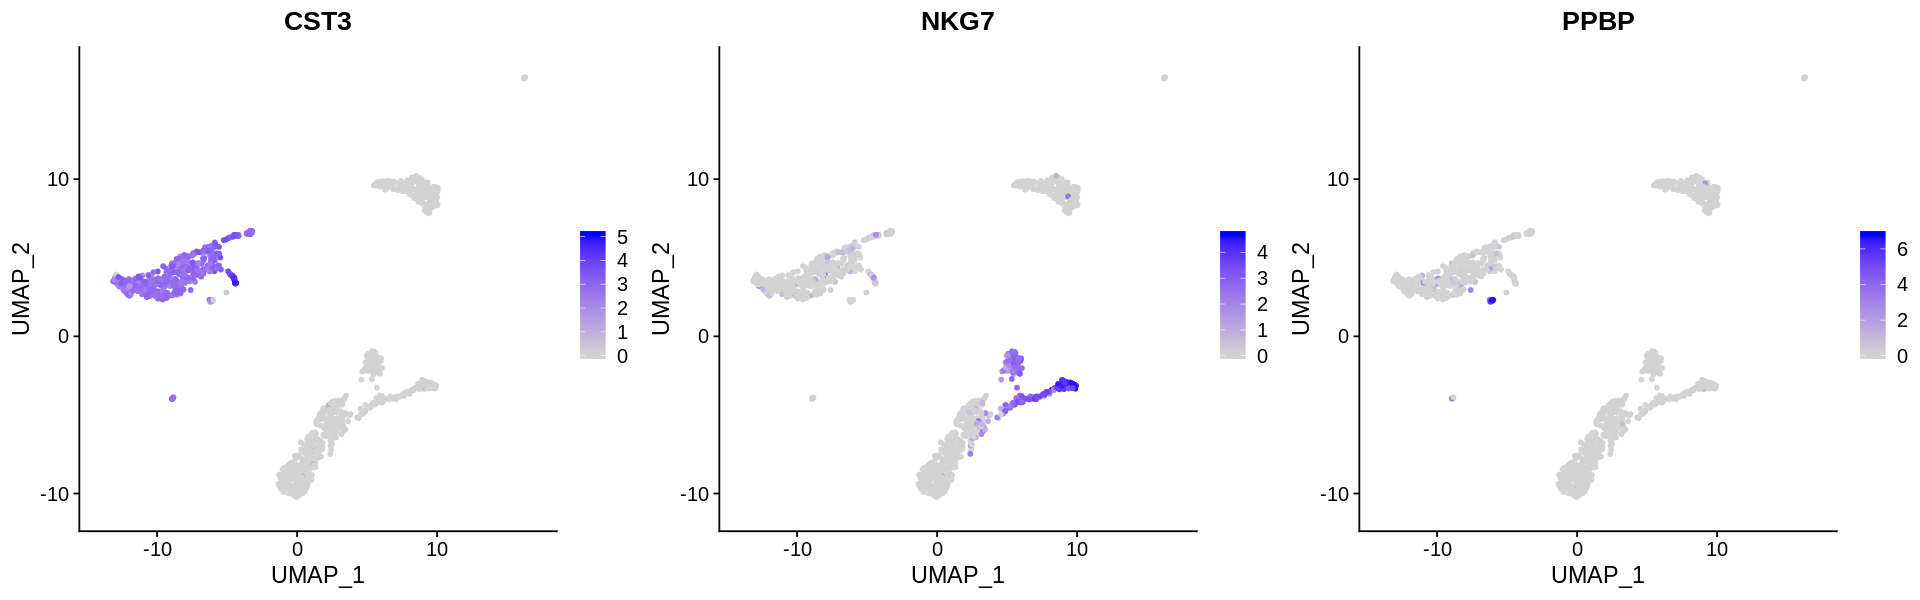

In [0]:
options(repr.plot.width=16, repr.plot.height=5)
FeaturePlot(pbmc, reduction = "umap", features = c("CST3", "NKG7", "PPBP"),
ncol = 3)

### Finding differentially expressed features (cluster biomarkers)
A key follow-up step to clustering cells is to find gene markers that are associated with them. We used Seurat's FindAllMarkers function which automates the process for all clusters.

The min.pct argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory. As another option to speed up these computations, max.cells.per.ident can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significiant and the most highly differentially expressed features will likely still rise to the top.

In [0]:
# Scanpy style gene rank plot
plot_gene_rank <- function(markers, n) {
  df_plot <- markers %>%
    group_by(cluster) %>%
    top_n(25, avg_logFC) %>%
    mutate(rank = factor(row_number(desc(avg_logFC))))
  ggplot(df_plot, aes(rank, avg_logFC)) +
    geom_text(aes(label = gene), angle = -90, hjust = 1) +
    facet_wrap(~ cluster) +
    scale_y_continuous(expand = expand_scale(mult = c(0.05, 0.25)))
}

Several methods for differential expression are supported by Seurat. The default is Wilcoxon rank sum test.

In [0]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, test.use = "wilcox", only.pos = TRUE, 
                               min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



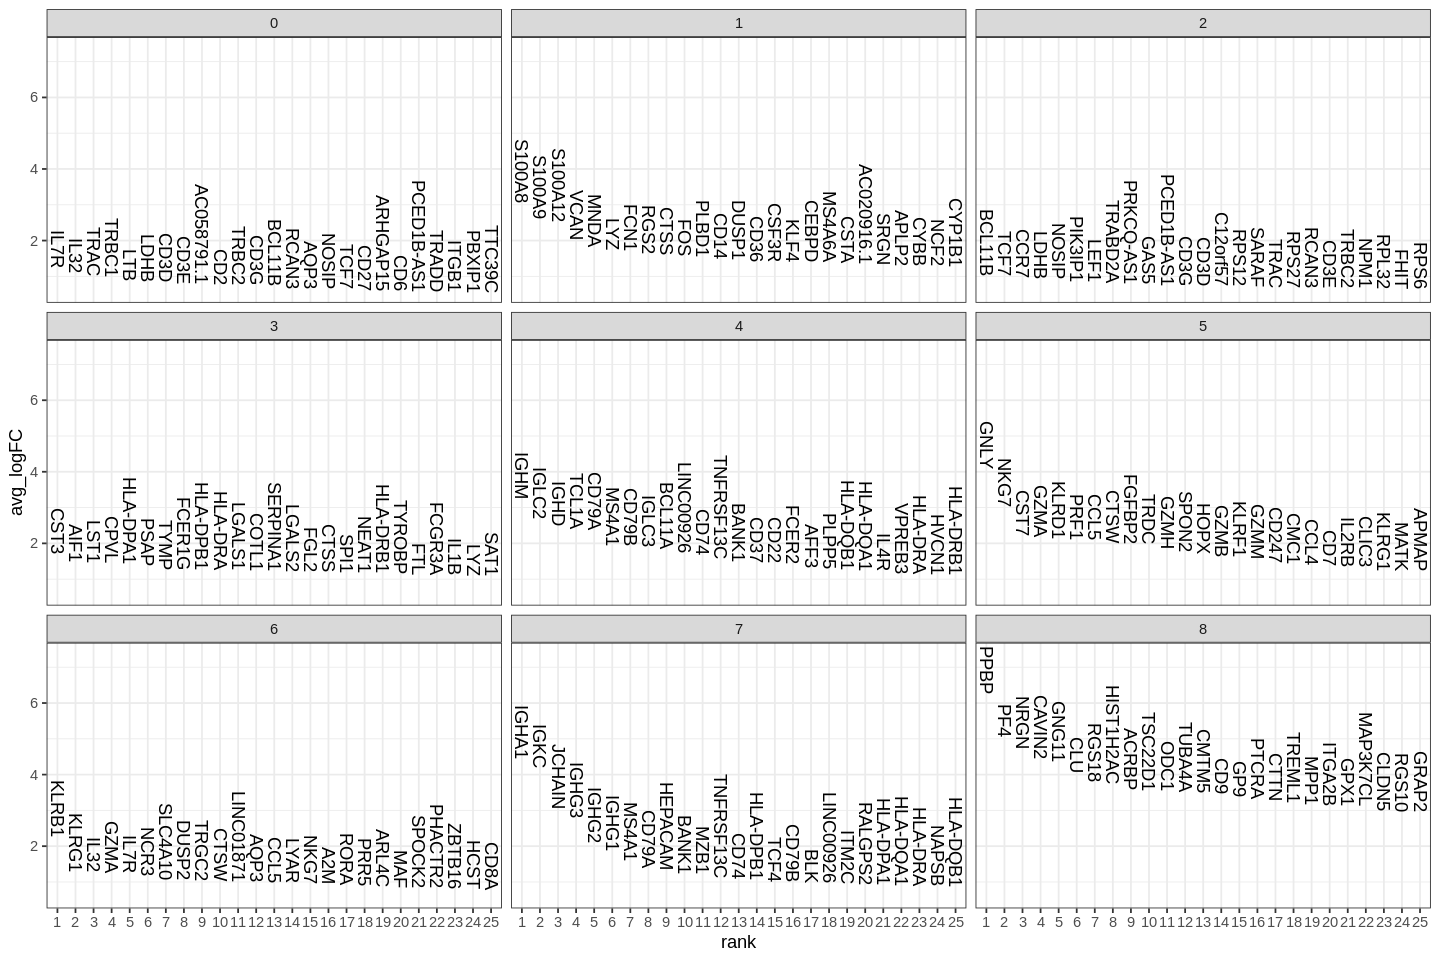

In [0]:
options(repr.plot.width=12, repr.plot.height=8)
plot_gene_rank(pbmc.markers, 25)

Student's t test is also supported

In [0]:
pbmc.markers.t <- FindAllMarkers(pbmc, test.use = "t", only.pos = TRUE, 
                               min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



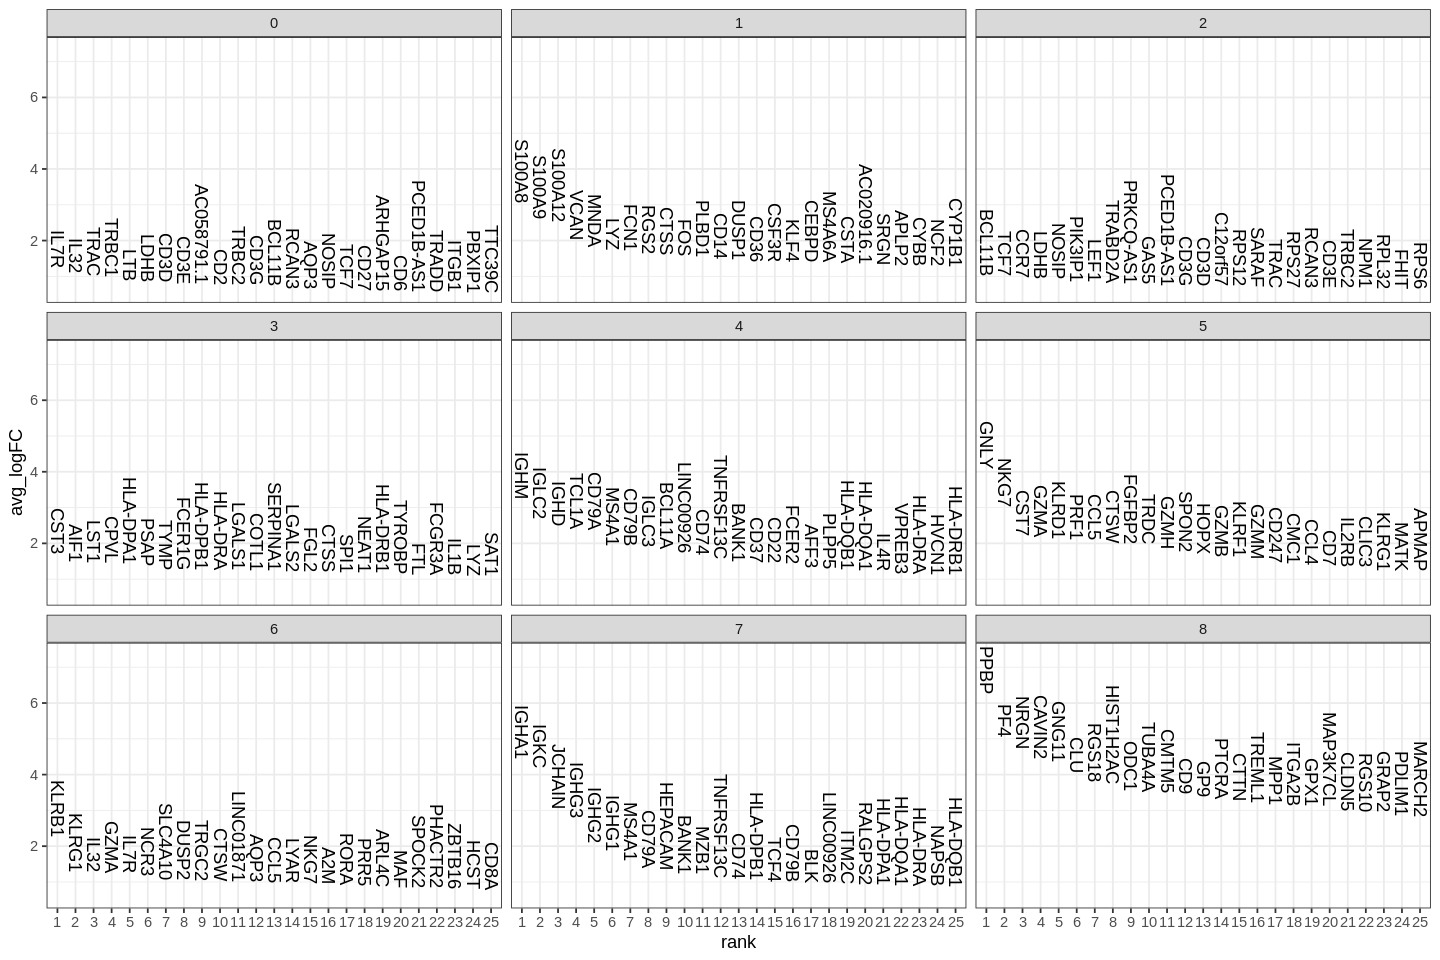

In [0]:
plot_gene_rank(pbmc.markers.t, 25)

Also logistic regression to test how good each gene is for deciding whether a cell is in a cluster.

In [0]:
pbmc.markers.lr <- FindAllMarkers(pbmc, test.use = "LR", only.pos = TRUE, 
                               min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Calculating cluster 8

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerica

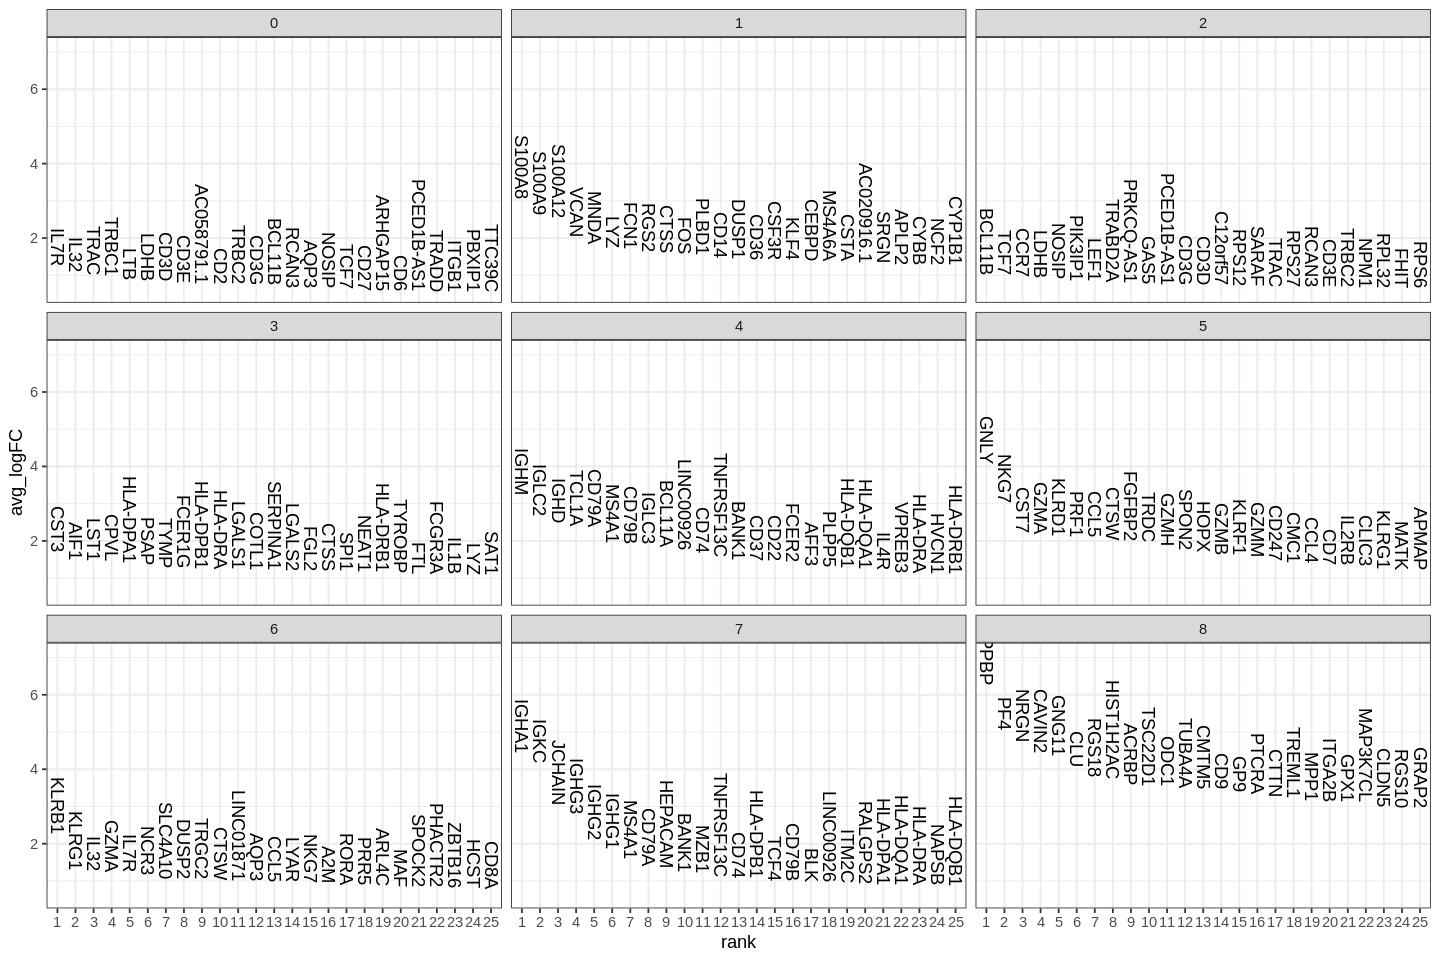

In [0]:
plot_gene_rank(pbmc.markers.lr, 25)

Seurat includes several tools for visualizing marker expression. VlnPlot (shows expression probability distributions across clusters), and FeaturePlot (visualizes feature expression on a tSNE or PCA plot) are our most commonly used visualizations. We also suggest exploring RidgePlot, CellScatter, and DotPlot as additional methods to view your dataset.



In [0]:
marker_genes <- sort(c('IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP', 'CCR7',
                'S100A4'))

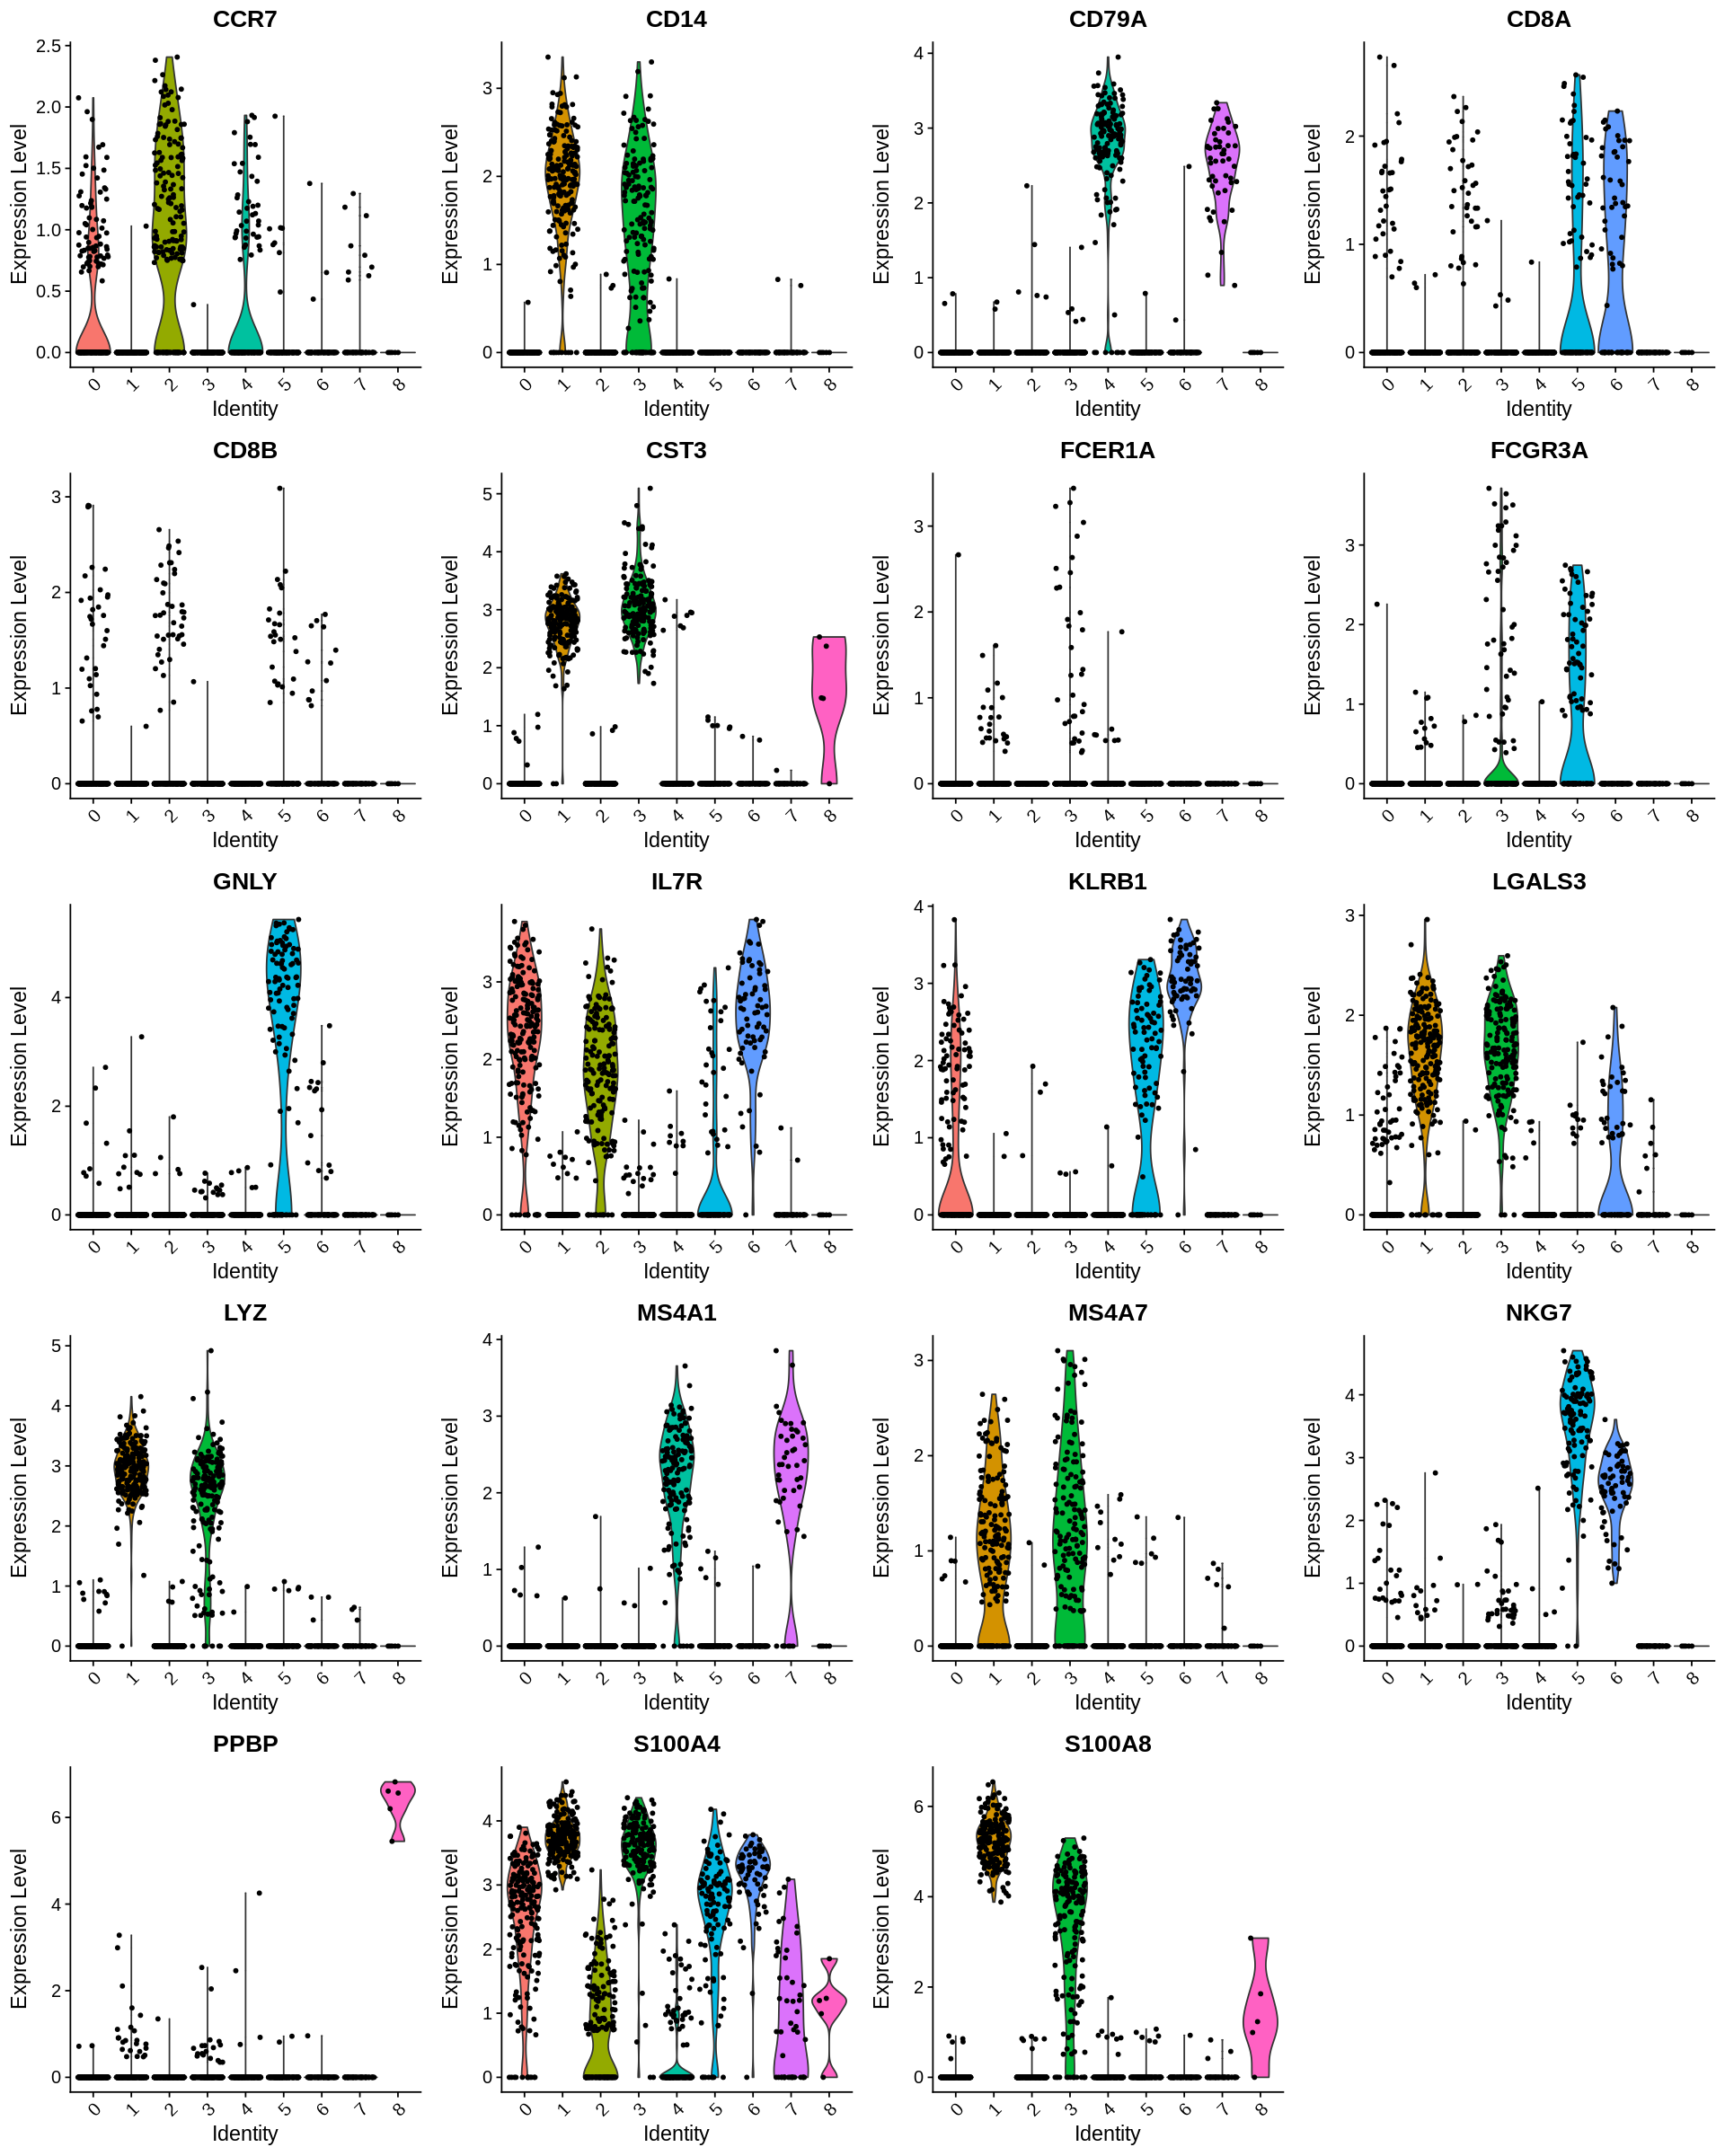

In [0]:
options(repr.plot.width=16, repr.plot.height=20)
VlnPlot(pbmc, features = marker_genes, ncol = 4)

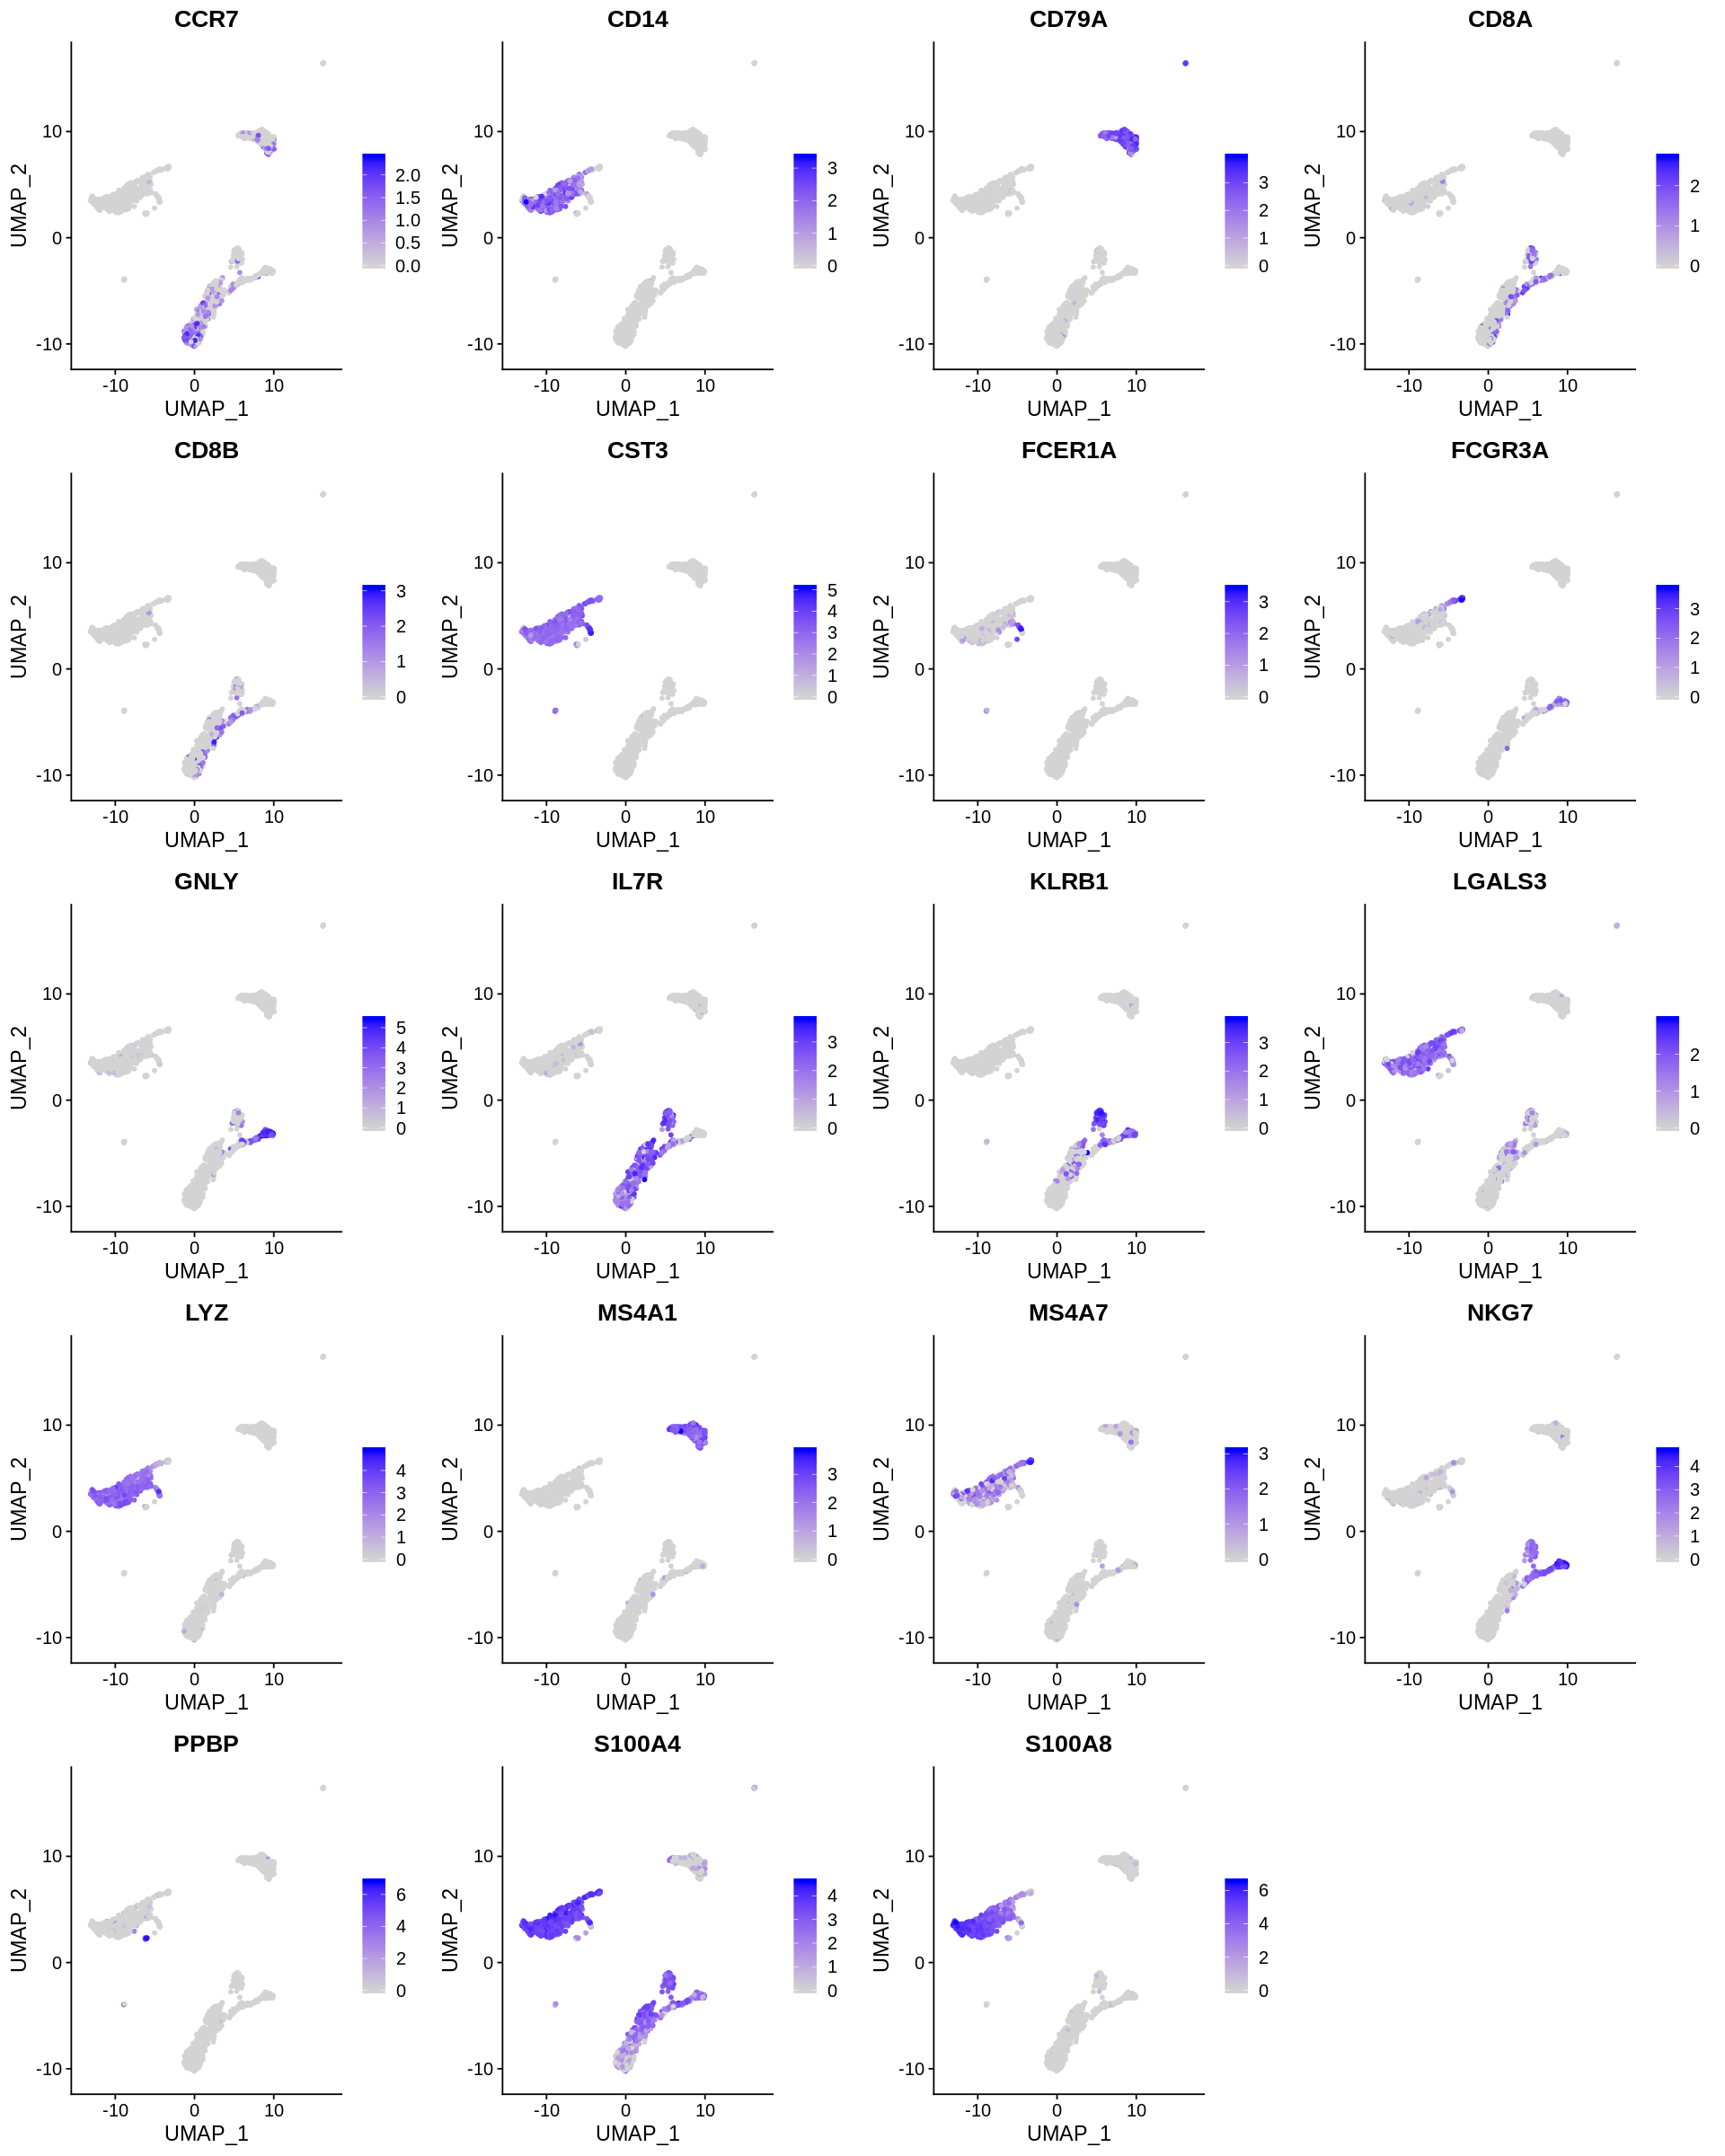

In [0]:
options(repr.plot.width=16, repr.plot.height=20)
FeaturePlot(pbmc, features = marker_genes, ncol = 4)

### Assigning cell type identity to clusters
In this dataset, we can use canonical markers to easily match the *de novo* clustering to known cell types:

Cluster ID | Markers | Cell Type
-----------|---------|-------------
0	| IL7R, S100A4 |	Memory CD4+ T
1 |	CD14, LYZ |	CD14+ Mono
2 |	IL7R, CCR7 |	Naive CD4+
3 |	FCGR3A, MS4A7 |	FCGR3A+ Mono
4 |	MS4A1, CD79A |	B
5 |	GNLY, NKG7 | NK
6 |	CD8A | CD8+ T
7 | MS4A1, CD79A | B
8 |	PPBP | Platelet

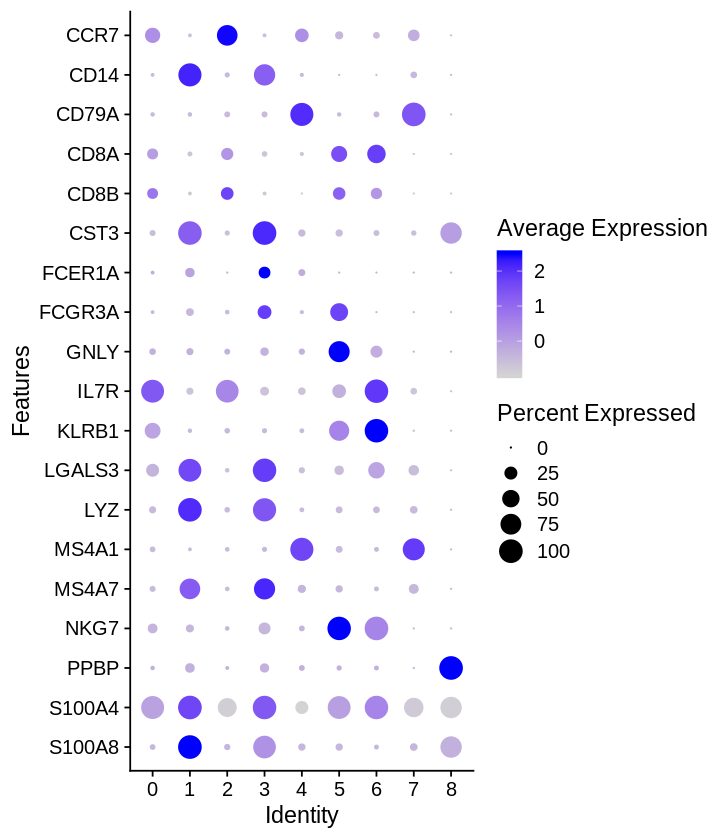

In [0]:
options(repr.plot.width=6, repr.plot.height=7)
DotPlot(pbmc, assay = "RNA", features = marker_genes, scale.by = "size") +
  coord_flip()

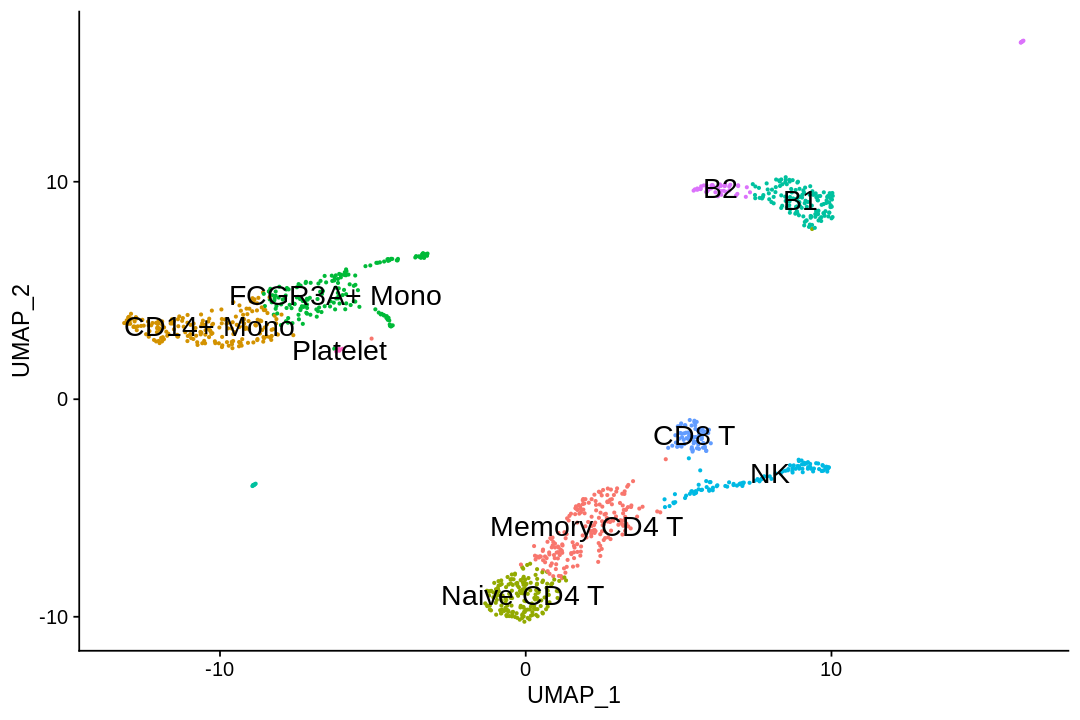

In [0]:
options(repr.plot.width=9, repr.plot.height=6)
new.cluster.ids <- c("Memory CD4 T", "CD14+ Mono", "Naive CD4 T", "FCGR3A+ Mono", 
    "B1", "NK", "CD8 T", "B2", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5, label.size = 6) + NoLegend()

In [0]:
Sys.time() - start_time

Time difference of 54.48928 mins

In [0]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scico_1.1.0                 forcats_0.4.0              
 [3] stringr_1.4.0               dplyr_0.8.4                
 [5] purrr_0.3.3                 readr_1.3.1                
 [7] tidyr_1.0.2                 tibble_2.1.3               
 [

**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_R.ipynb).